# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нам нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Мы будем искать закономерности, особенности и зависимости, которые существуют на рынке недвижимости. На первом этапе мы выполним предобработку данных, далее изучим характеристики объектов недвижимости и исследуем вопрос, какие факторы и как влияют на цену объекта недвижимости.

### Загрузка данных и разведочный анализ. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


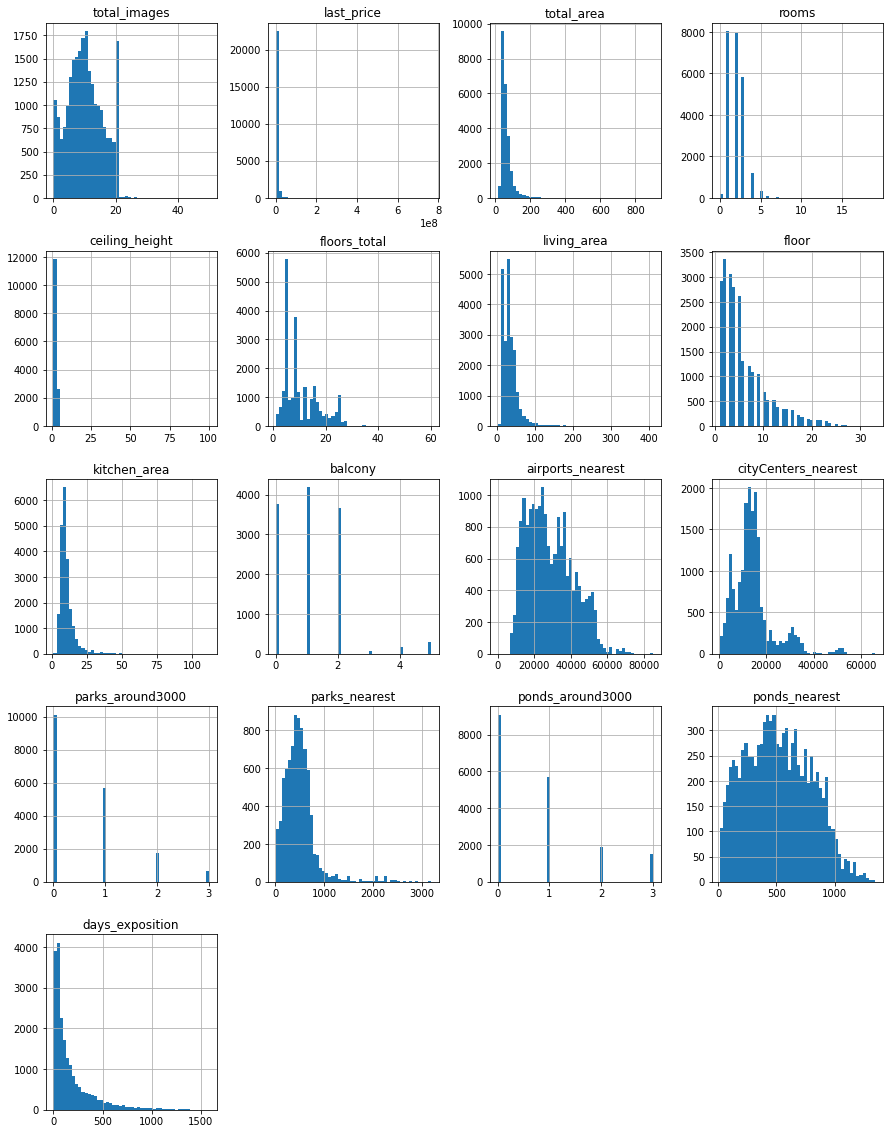

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    print('неверный путь к файлу')
data.info()
display(data.head())
data.hist(figsize=(15, 20),bins=50)
plt.show();

### Предобработка данных

Количество дубликатов в данных: 0
count    23533.000000
mean        60.323059
std         35.673365
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
count    2.171400e+04
mean     5.102527e+06
std      3.008591e+06
min      4.300000e+05
25%      3.340000e+06
50%      4.450000e+06
75%      6.100000e+06
max      5.300000e+07
Name: last_price, dtype: float64
Количество уникальных локаций: 363
Количество уникальных локаций после удаления дубликатов: 321
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12202 entries, 9 to 23532
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          12202 non-null  int64  
 1   last_price            12202 non-null  float64
 2   total_area            12202 non-null  float64
 3   first_day_exposition  12202 non-null  object 
 4   rooms                 12202 non-

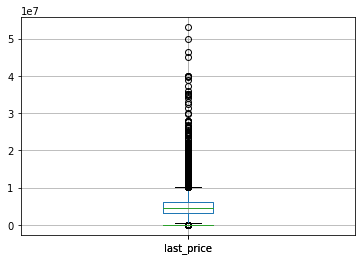

In [2]:
print('Количество дубликатов в данных:', data.duplicated().sum())
#median2=data.query('(ceiling_height<4) & (ceiling_height>2)')['ceiling_height'].median()

#удаляем строки, содержание пропуски в общем количестве этажей
data=data.dropna(subset=['floors_total']).reset_index(drop=True)

#приводим стобец с общим количеством этажей к целому типу
data=data.query('floors_total <= 30')
data['floors_total']=data['floors_total'].astype('int')

#заполняем значения столбца is_apartment значением False
data['is_apartment']=data['is_apartment'].fillna('False')
data['is_apartment']=data['is_apartment'].astype('bool')

#Заполняем пропуски в количестве балконов нулями, приводим значения в столбце к целому типу
data['balcony']=data['balcony'].fillna(0)
data['balcony']=data['balcony'].astype('int')

#удаляем строки, содержание пропуски в названии локации
data=data.dropna(subset=['locality_name']).reset_index(drop=True)

#Заполняем нулями пропуски в столбцах, приводим значения к целому типу
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype('int')

#days_median = data['days_exposition'].median()
#data['days_exposition'] = data['days_exposition'].fillna(days_median)
#data['days_exposition'] = data['days_exposition'].astype('int')
#display(data.query('days_exposition.isna()'))

#устраняем пропуски в жилой прощади
data.loc[data['living_area'].isna(), 'living_area'] = data['total_area']-2*data['kitchen_area']

#устраняем пропуски в площади кухни
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (data['total_area']-data['living_area'])*0.5

#обработаем выбросы в total_area
print(data['total_area'].describe())
data.boxplot('total_area')
data = data.query('(total_area<101)&(total_area>20)')

#устраняем выбросы в last_price
print(data['last_price'].describe())
data.boxplot('last_price')
data=data.query('last_price<9625000')


#устраняем дубликаты в локациях
print("Количество уникальных локаций:", len(data['locality_name'].unique()))
def location_rename(location):
    if location.find('поселок')!=-1:
        location=location.replace('поселок', 'посёлок')
    if location.find('городской посёлок')!=-1:
        location=location.replace('городской посёлок','посёлок городского типа')
    if location.find('Мурино')!=-1:
        location='посёлок Мурино'
    return location
data['locality_name']=data['locality_name'].apply(location_rename)
print("Количество уникальных локаций после удаления дубликатов:", len(data['locality_name'].unique()))
localities = data['locality_name'].unique()

#заполняем пропуски столбца высоты потолков медианным значением по населенному пункту, а оставшиеся - по всему датасету, удаляем строки, в которых значение высоты потолков больше 
#4, либо меньше 2 метров
data=data.query('(ceiling_height<4) & (ceiling_height>2)')
median_total=data['ceiling_height'].median()
for locality_name in localities:
    median = data[data['locality_name']==locality_name]['ceiling_height'].median()
    data.loc[(data['locality_name']==locality_name)&(data['ceiling_height'].isna()),'ceiling_height']=median
data['ceiling_height']=data['ceiling_height'].fillna(median_total)
data.info()

Причины **появления пропусков** делятся на технические (например, при публикации объявления продавец забыл указать данные, не имел доступа к данным) и смысловые, когда отсутствие значений означает либо отсутствие объектов (балконов в квартире, водоемов в пешей доступности), либо значение не имеет смысла для данного объекта (расстояние до центра города в деревенском объекте, расстояние до аэропорта в случае удаленного объекта).

Касательно **типов данных** мы можем наблюдать, что некоторые столбцы, состоящие из целочисленных по смыслу данных, тем не менее, имеют тип float64, полагаю, это связано с наличием в данных значений NaN, имеющих тип float

### Подсчёт и добавление в таблицу новых столбцов

In [3]:
#добавление столбца с ценой квадратного метра
data['meter_price'] = data['last_price']/data['total_area']

#добавляем столбец с расстоянием до центра города в километрах
data['distance'] = data['cityCenters_nearest']//1000

#функция, определяющая категорию этажа: первый этаж - 0, последний этаж - 2, другой этаж - 1
def categorize_floor(row):
    floor=row['floor']
    total_floors=row['floors_total']
    if floor==1:
        return 1
    if floor==total_floors:
        return 3
    return 2

#добавление столбца, категоризирующего этаж
data['floor_category']=data.apply(categorize_floor, axis=1)

#добавление столбца, категоризирующего месяц
data['month']=pd.DatetimeIndex(data['first_day_exposition']).month

#добавление столбца, категоризирующего год
data['year']=pd.DatetimeIndex(data['first_day_exposition']).year

#добавление столбца, категоризирующего день недели 
data['dayofweek']=pd.DatetimeIndex(data['first_day_exposition']).dayofweek
    
#добавление столбца, маркирующего подозрительные квартиры
data['suspect']=(data['living_area'].isna())
display(data.query('suspect==True').head())



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,meter_price,distance,floor_category,month,year,dayofweek,suspect
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5,NaN,1,True,...,0,NaN,196.0,43449.781659,NaN,1,10,2017,5,True
226,13,2200000.0,47.0,2018-01-12T00:00:00,3,2.34,5,NaN,1,True,...,0,NaN,45.0,46808.510638,NaN,1,1,2018,4,True
302,2,2950000.0,32.0,2018-02-01T00:00:00,1,2.50,5,NaN,1,True,...,0,NaN,43.0,92187.500000,15.0,1,2,2018,3,True
390,10,3900000.0,41.3,2018-01-19T00:00:00,2,2.55,5,NaN,3,True,...,0,NaN,45.0,94430.992736,11.0,2,1,2018,4,True
468,1,6910000.0,62.7,2018-09-28T00:00:00,3,2.55,10,NaN,7,True,...,1,782.0,120.0,110207.336523,14.0,2,9,2018,4,True


### Исследовательский анализ данных

count    10353.000000
mean       176.718632
std        214.303026
min          1.000000
25%         43.000000
50%         95.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64
Санкт-Петербург      7984
Всеволожск            263
посёлок Мурино        225
посёлок Шушары        210
Пушкин                204
Колпино               198
Гатчина               144
Петергоф              137
посёлок Парголово     136
деревня Кудрово       121
Name: locality_name, dtype: int64
['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']
                     meter_price
locality_name                   
Всеволожск          66749.189959
Выборг              58947.028129
Гатчина             69824.382475
Колпино             75935.260630
Пушкин              99802.350554
Санкт-Петербург    104811.857418
деревня Кудрово     90487.341293
посёлок Мурино      87816.169369
посёлок Па

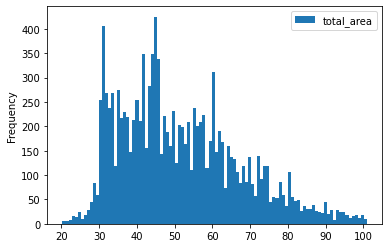

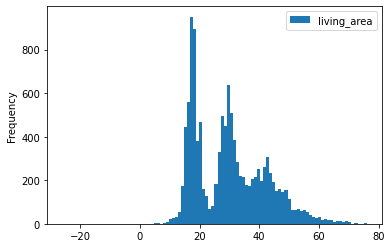

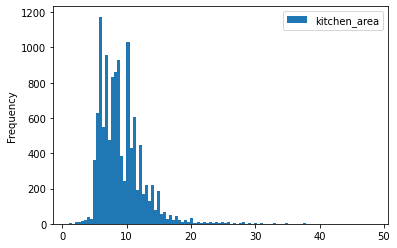

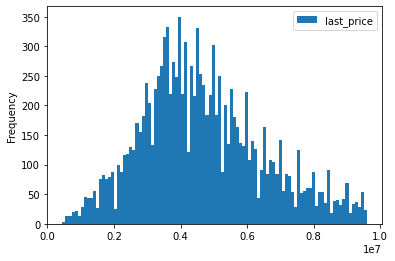

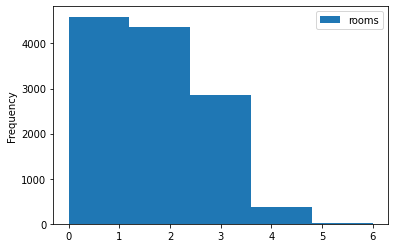

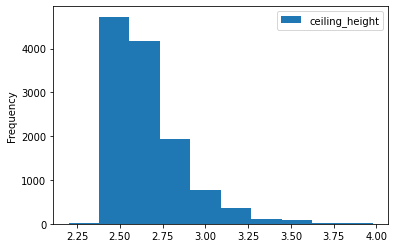

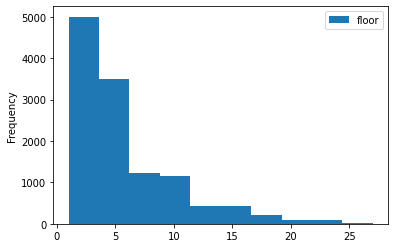

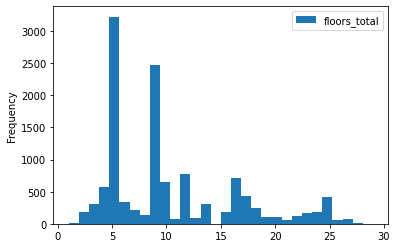

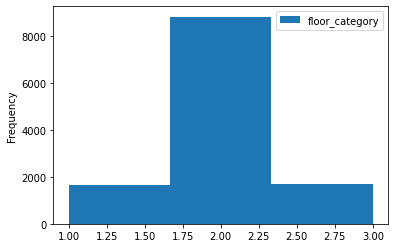

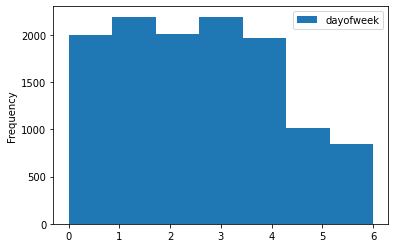

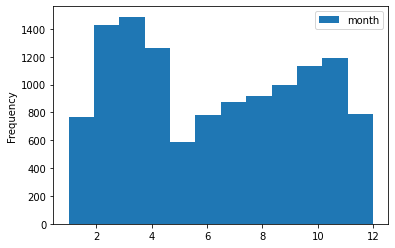

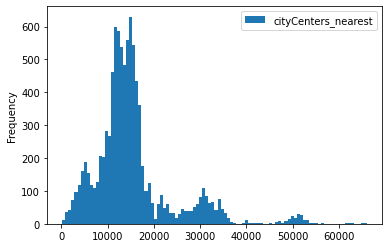

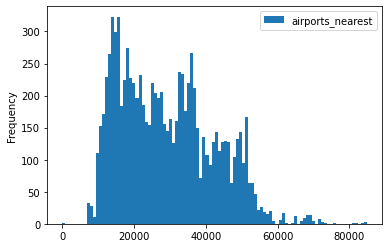

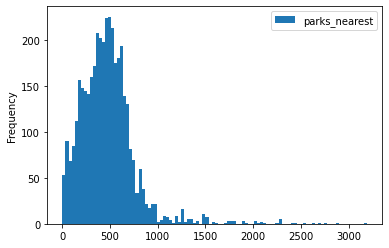

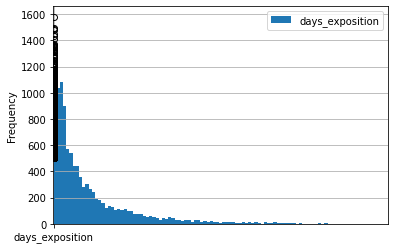

In [4]:
data.plot(y='total_area', kind='hist', bins=100)
data.plot(y='living_area', kind='hist', bins=100)
data.plot(y='kitchen_area', kind='hist', bins=100)
data.plot(y='last_price', kind='hist', bins=100)
data.plot(y='rooms', kind='hist', bins=5)
data.plot(y='ceiling_height', kind='hist', bins=10)
data.plot(y='floor', kind='hist', bins=10)
data.plot(y='floors_total', kind='hist', bins=30)
data.plot(y='floor_category', kind='hist', bins=3)
data.plot(y='dayofweek', kind='hist', bins=7)
data.plot(y='month', kind='hist', bins=12)
data.plot(y='cityCenters_nearest', kind='hist', bins=100)
data.plot(y='airports_nearest', kind='hist', bins=100)
data.plot(y='parks_nearest', kind='hist', bins=100)

data.plot(y='days_exposition', kind='hist', bins=100)
data.boxplot('days_exposition')
print(data['days_exposition'].describe())
      
print(data['locality_name'].value_counts().head(10))
most_popular=['Санкт-Петербург','посёлок Мурино','посёлок Шушары','Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']
print(most_popular)
print(data.query('locality_name in @most_popular').pivot_table(index='locality_name', values='meter_price'))




### Общий вывод

#### Предобработка данных
В рамках предобработки данных мы проделали следующие действия:
- Поскольку доля объектов, содержащих пропуски в колонке `total_floor`, невелико, то мы удалили сооветствующие строки. Кроме столбец `total_floor` приведен к целому типу.
- Пропущенные значения столбца `is_apartment` заполнены значениями False, так как логично, что эти объекты не являются апартаментами.
- Проущенные значения столбца `ceiling_height`заполнили медианным значением, вычисленным по столбцу и равным 2.65, удаляем строки, соответствующие объектам с высотой потолка больше 4, либо меньше 2. Заменим, что удаление выбросов не повлияло на медиану (median1  и median2 в коде).
- Заполнили нулями отсутствующие значения с столбцах `balcony`, `ponds_around3000`, `parks_around3000`, поскольку логично предположить, что отсутвие значений означает отсутствие соответствующий объектов. Кроме того, данные в этих столбцах приведены к целому типу.
- Мы удалили объекты, в которых значение `total_area` было больше 101 метра и меньше 20 метров. Такие объекты существуют, но в случае больших квартир речь, скорее всего, идёт о нестандартных объединённых квартирах, а в случае малых объектов - о долевой собственности. Такие объекты можно удалить из исследования, поскольку они только внесут искажения.
- Мы удалили объекты с пропусками в названии населённого пункта (таких объектов было мало) и устранили неявные дубликаты в локациях.
- Мы заполнили пропущенные значения `living_area` значениями `total_area`-2х`kitchen_area` и наоборот `kitchen_area` =(`total_area` - `living_area`)х0.5, предполагая, что нежилая площадь поровну делится между кухней и коридором с санузлом. Это не самый лучший способ заполнить пропуски, поскольку точные значения площади коридора и санузла отсутствуют, но возможный. Квартиры, в которых значения `living_area` и `kitchen_area` отсутствуют, помечены как подозрительные (добавлен столбец `suspect`). Мы полагаем, что отдельно жилую площадь или площадь кухни продавец мог не добавить по ошибке, но отсутствие обоих показателей наводит на подозрения относительно того, существует ли объект продажи в реальности.
- Мы ограничились рассмотрением объектов ценой ниже 9.625 млн, то есть ниже правой границы диаграммы размаха. 
- Мы не стали заполнять пропущенные значения количества дней экспозиции медианным значением времени продажи, поскольку такое заполнение может исказить исследование (из-за искажения среднего значения). 
- Остальные столбцы мы оставили без изменений, считая пропуски. Полагаем, что некоторые характеристики, например, расстояние до центра города, не имеют смысла для объектов, находящихся вне городов. Аналогично, расстояние до аэропорта может быть не указано для тех объектов, где оно слишком большое. Пропуски в столбцах, касающихся дополнительных характеристик объекта (расстояние до аэропорта, до центра города, до парков и прудов), обусловлены, скорее всего, тем, что они не являются выгодными для продажи, и продавец не указывал их в объявлении.
- Мы добавили столбцы, характеризующие месяц, год, день недели размещения объявления, столбец с ценой квадратного метра, с расстоянием до центра города там, где это возможно, а также столбца, характеризующего этаж (0 - первый этаж, 2 - последний этаж, 1 - другой этаж).


### Исследовательский анализ данных
#### Основные параметры объектов: общая площадь, жилая площадь, цена, количество комнат, высота потолков, этажность, расстояние до центра города, до аэропорта, до парка

<AxesSubplot:ylabel='Frequency'>

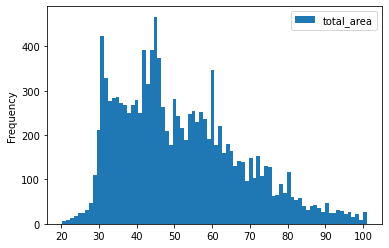

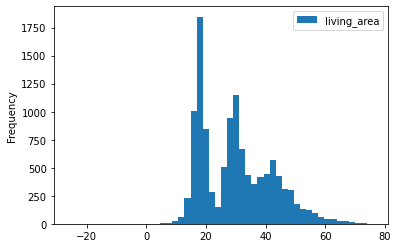

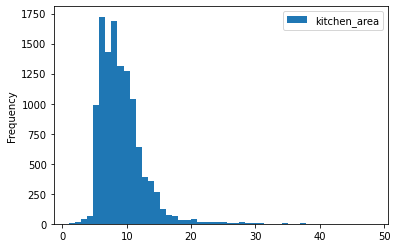

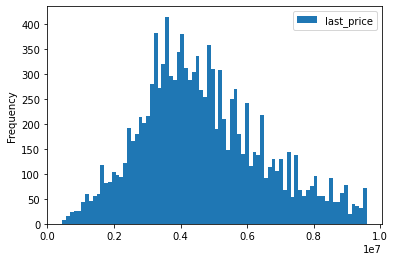

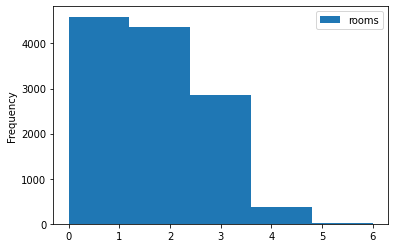

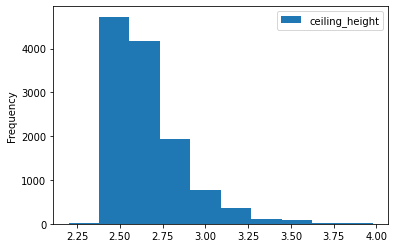

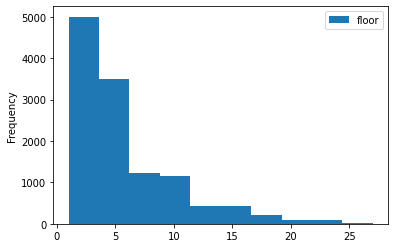

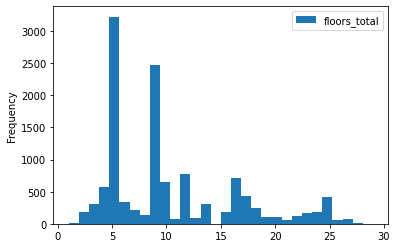

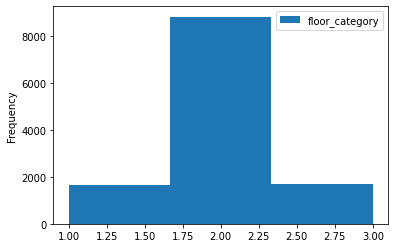

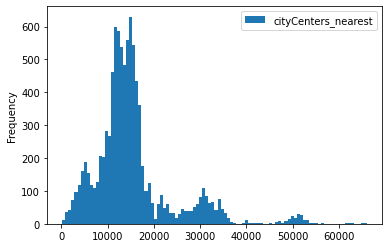

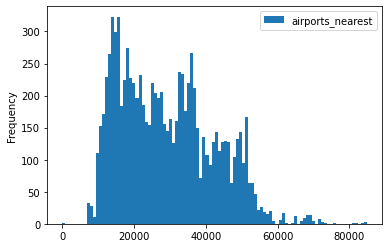

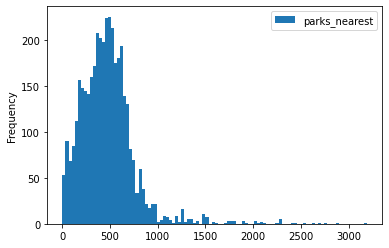

In [5]:
data.plot(y='total_area', kind='hist', bins=80)
data.plot(y='living_area', kind='hist', bins=50)
data.plot(y='kitchen_area', kind='hist', bins=50)
data.plot(y='last_price', kind='hist', bins=80)
data.plot(y='rooms', kind='hist', bins=5)
data.plot(y='ceiling_height', kind='hist', bins=10)
data.plot(y='floor', kind='hist', bins=10)
data.plot(y='floors_total', kind='hist', bins=30)
data.plot(y='floor_category', kind='hist', bins=3)
data.plot(y='cityCenters_nearest', kind='hist', bins=100)
data.plot(y='airports_nearest', kind='hist', bins=100)
data.plot(y='parks_nearest', kind='hist', bins=100)

Гистограммы распределений, характеризующих объекты, позволяют сделать следующие выводы:
- больше всего объектов имеет площадь от 30 до 80 метров, что соответствует стандартным 1, 2, 3-комнатным квартирам, при этом график общей площади косвенно свидетельствует, что 1-комнатных квартир больше, чем 2-комнатных, а 3-комнатных существенно меньше
- жилая площадь также имеет несколько "горбиков", соответствующих 1, 2, 3-комнатным квартирам
- гистограмма цены объекта имеет форму нормального распределения, но со смещением в сторону более дешевых объектов, что логично, так как объектов меньшей площади в продаже больше
- гистограмма числа комнат четко показывает, что 1-комнатных квартир продается больше всех, 2-комнатных немного меньше, 3-комнатных вдвое меньше, а 4 и более комнатных очень небольшой процент
- высота пололков имеет четко выраженный пик в окрестности 2.65 - стандартной высоты пололка, но присутствуют и объекты с высокими потолками
- гистограмма этажа объекта показывает, что с ростом этажа количество выставленных на продажу квартир снижается
- гистограмма этажности здания имеет четко выраженные пики на 5, 8, 12, 16, 25 - этажных зданиях, что опять же соответствует тенденциям в городском строительстве
- гистограмма категории этажа (первый, последний, средний) показывает, что большинство объектов располагается на средних этажах, а первом и последнем - существенно меньше, причём одинаково
- гистограмма расстояния до центра города выглядит как наложенные гистограммы нормальных распределений, что, по-видимому, соответствует группировке по разным городам
- гистограмма расстояния до ближайшего парка имеет форму нормального распределения

**Вывод:** Данные выглядят правдоподобно и отражают отражают текущую ситуацию в городском жилищном строительстве.

##### Параметры объявления: день недели и месяц публикации объявления

<AxesSubplot:ylabel='Frequency'>

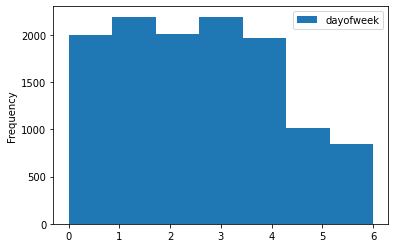

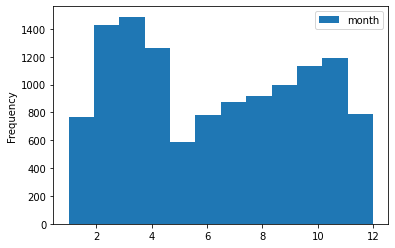

In [6]:
data.plot(y='dayofweek', kind='hist', bins=7)
data.plot(y='month', kind='hist', bins=12)

Гистограмма дня недели публикации объявления показывает, что подавляющее большинство объявлений публикуется в течение рабочей недели, что логично с учетом рабочих часов риэлтеров. Новые объявления публикуются преимущественно в весенние и осенние месяцы с провалами в летние месяцы и в новогодний период.

##### Анализ скорости продажи квартиры

count    10353.000000
mean       176.718632
std        214.303026
min          1.000000
25%         43.000000
50%         95.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64


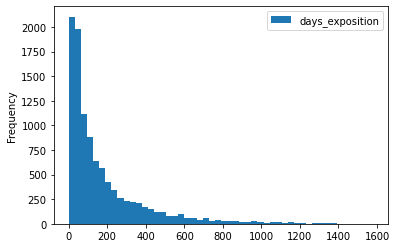

In [7]:
data.plot(y='days_exposition', kind='hist', bins=50)
#data.boxplot('days_exposition')
print(data['days_exposition'].describe())

Согласно гистограмме скорости продажи квартиры большинство объектов продается в течение полугода с момента публикации объявления (медиана - 89 дней, третий квартиль - 188 дней). Тем не менее, выборочное среднее времени продажи сильно отличается от медианного (159 дней против 89). Такая разница может свидетельствовать о существовании экстремально долгих продаж. Мы можем считать экстремально долгой продажей продажу за `Q3+1.5*IQR = 402` дня и больше.

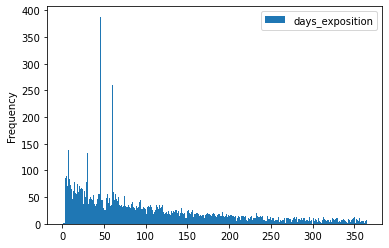

In [8]:
data.query('days_exposition<=365').plot(y='days_exposition', kind='hist', range=(0,365), bins=365)
plt.show();

При укрупнении гистограммы мы видим несколько выбивающихся из общей картины пиковых значений, когда в один день снимается с продажи от 200 до 800 (!) квартир. Можно предположить, что эти объекты, на самом деле, не проданы, но снимаются с продажи в связи с окончанием контракта с риелтером, либо для того, чтобы заново их разместить (по другой цене, либо просто переместить в раздел новых объявлений).

##### Влияние различных факторов на стоимость объекта?

Коэффициент корреляции в населенном пункте Санкт-Петербург равен 0.767778955649899
Коэффициент корреляции в населенном пункте посёлок Мурино равен 0.8737158119189246
Коэффициент корреляции в населенном пункте посёлок Шушары равен 0.8537938578661277
Коэффициент корреляции в населенном пункте Всеволожск равен 0.8620769940338486
Коэффициент корреляции в населенном пункте Пушкин равен 0.8540072838741637
Коэффициент корреляции в населенном пункте Колпино равен 0.8390632216587015
Коэффициент корреляции в населенном пункте посёлок Парголово равен 0.7625554058874895
Коэффициент корреляции в населенном пункте Гатчина равен 0.8071396536860576
Коэффициент корреляции в населенном пункте деревня Кудрово равен 0.8984567188168924
Коэффициент корреляции в населенном пункте Выборг равен 0.8417257221195251


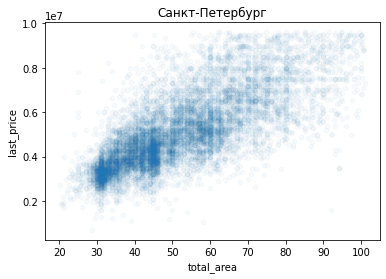

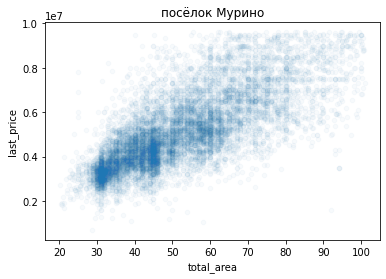

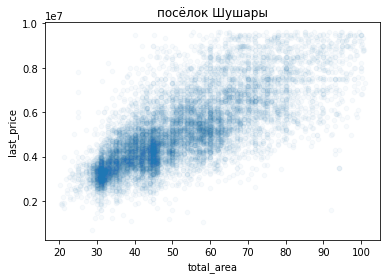

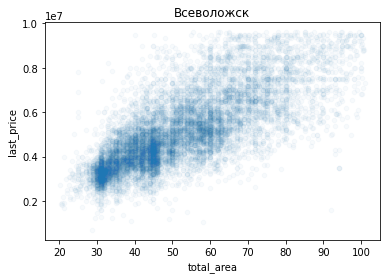

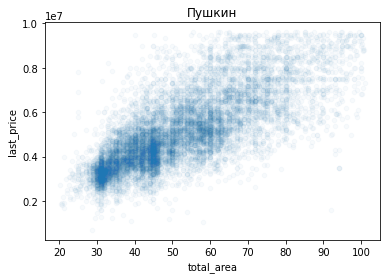

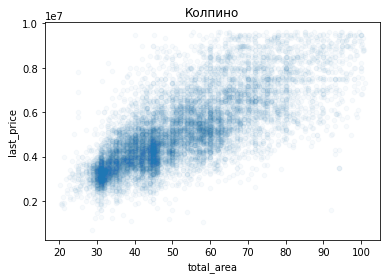

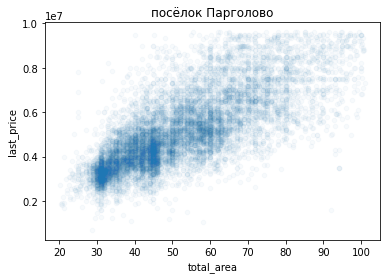

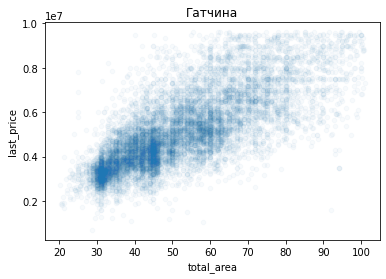

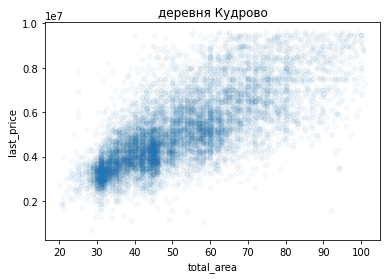

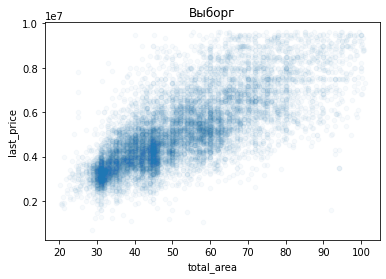

In [9]:
for locality_name in most_popular:
    data.query('locality_name in @most_popular').plot(x='total_area',y='last_price', kind='scatter', alpha=0.03, title=locality_name, legend=True)
    cor=data.query('locality_name==@locality_name')['total_area'].corr(data.query('locality_name==@locality_name')['last_price'])
    print('Коэффициент корреляции в населенном пункте', locality_name, 'равен',cor)

Построив диаграммы рассеяния для 10 наиболее популярных населенных пунктов видим, что с ростом площади объекта имеет место рост цены. Коэффициент корреляции по каждому городу высок. При этом в каждом населенном пункте продается большое число объектов одинаковой площади по разной цене, таким образом нельзя сказать, что корреляция однозначно имеет место.

Коэффициент корреляции равен 0.6454618221307593


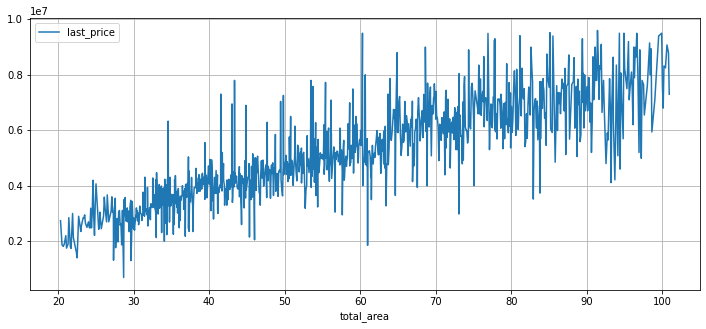

In [10]:
data.pivot_table(index='total_area', values='last_price').plot(grid=True, figsize=(12, 5))
cor=data['total_area'].corr(data['last_price'])
print('Коэффициент корреляции равен',cor)

График зависимости цены от площади, построенный по сводной таблице (здесь уже  по всему датасету) также показывает рост цены в зависимости от площади. Заметим, что коэффициент корреляции по всему датасету оказывается ниже, чем при дополнительной разбивке по городам.

Коэффициент корреляции равен 0.5163756399190575


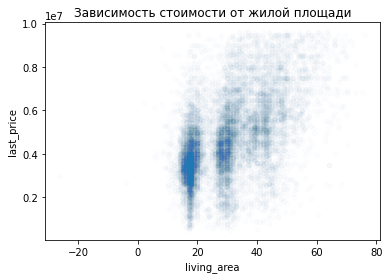

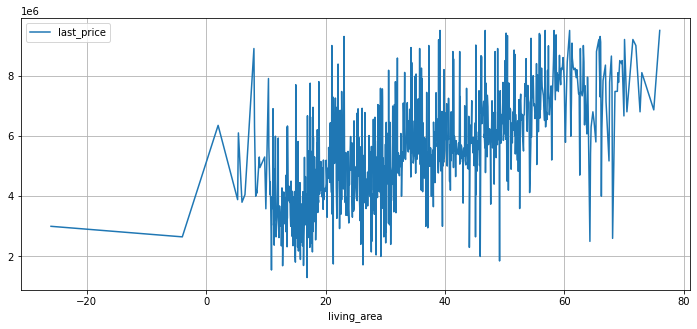

In [11]:
data.plot(x='living_area',y='last_price', kind='scatter', title='Зависимость стоимости от жилой площади', alpha=0.01)
data.pivot_table(index='living_area', values='last_price').plot(grid=True, figsize=(12, 5))
cor=data['living_area'].corr(data['last_price'])
print('Коэффициент корреляции равен',cor)

С ростом жилой площади имеет место рост цены, но коэффициент корреляции ниже, чем при исследовании зависимости цены объекта от общей площади. Скорее всего, зависимость стоимости от общей площади вторична.


Коэффициент корреляции равен 0.43529945874438764


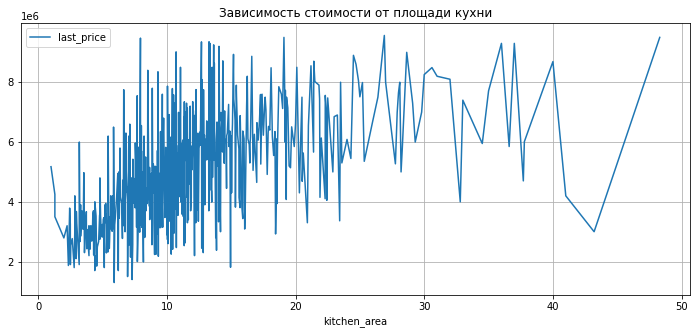

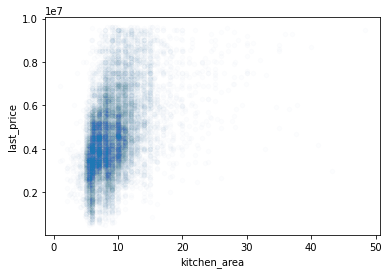

In [12]:
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, title='Зависимость стоимости от площади кухни', figsize=(12, 5))
data.plot(x='kitchen_area',y='last_price', kind='scatter', alpha=0.01)
cor=data['kitchen_area'].corr(data['last_price'])
print('Коэффициент корреляции равен',cor)

По графику мы видим, что есть определенная зависимость стоимости объекта от площади кухни объекто в площадью кухни меньше 20 метров, но коэффициент корреляции довольно низок.

Коэффициент корреляции равен 0.4067276427750366


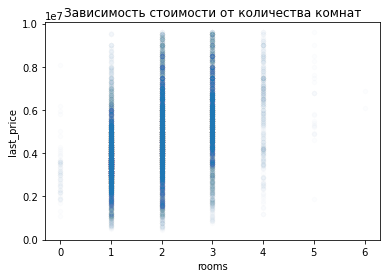

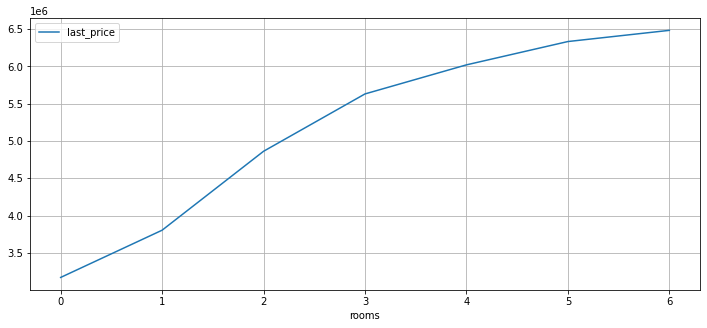

In [13]:
data.plot(x='rooms',y='last_price', kind='scatter', title='Зависимость стоимости от количества комнат', alpha=0.01)
data.pivot_table(index='rooms', values='last_price').plot(grid=True, figsize=(12, 5))
cor=data['rooms'].corr(data['last_price'])
print('Коэффициент корреляции равен',cor)

<AxesSubplot:xlabel='floor_category'>

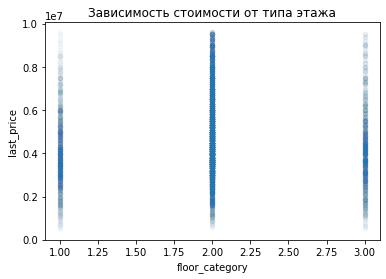

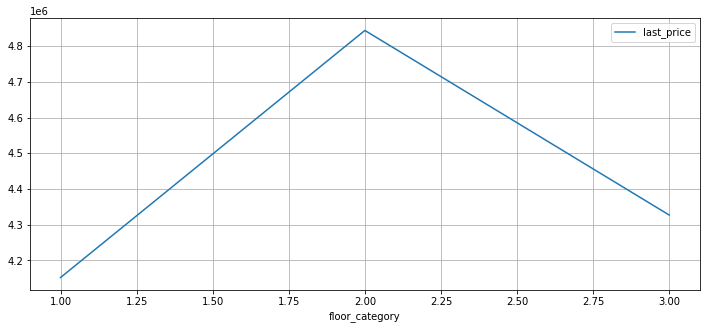

In [14]:
data.plot(x='floor_category',y='last_price', kind='scatter',title='Зависимость стоимости от типа этажа', alpha=0.01 )
data.pivot_table(index='floor_category', values='last_price').plot(grid=True, figsize=(12, 5))

Дешевле всех стоят квартиры на первом этаже, немного дороже - на последнем этаже, наиболее дорогие - на средних этажах.

<AxesSubplot:title={'center':'Зависимость стоимости от времени размещения (день)'}, xlabel='dayofweek'>

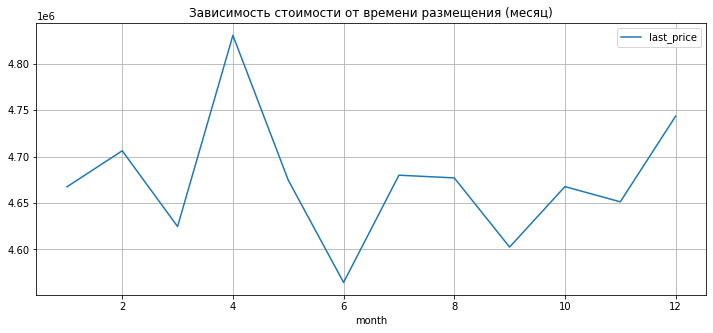

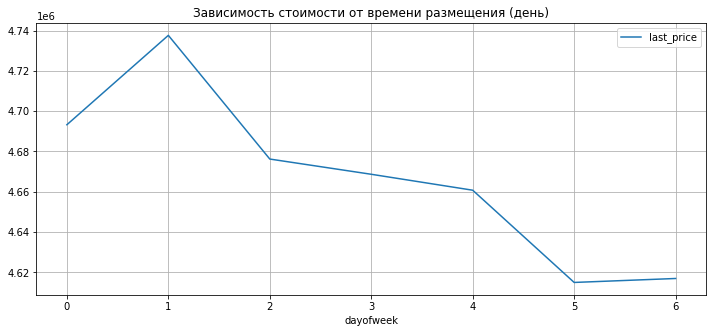

In [15]:
data.pivot_table(index='month', values='last_price').plot(grid=True, figsize=(12, 5), title='Зависимость стоимости от времени размещения (месяц)')
data.pivot_table(index='dayofweek', values='last_price').plot(grid=True, figsize=(12, 5), title='Зависимость стоимости от времени размещения (день)')

Самые дешевые квартиры помещают в продажу в летние месяцы, что коррелирует с общим спадом продаж в это время. Также более дорогие квартиры размещают в течение рабочей недели, а более дешевые варианты - в выходные дни.

**Вывод:** Мы видим, что на стоимость объекта влияет множество факторов, главным из которых является общая площадь и типа этажа. Также на цену квартиры оказывает влияние время продажи.

##### Анализ объявлений в населенных пунктах с наибольшим числом объявлений

In [16]:
print(data.query('locality_name in @most_popular').pivot_table(index='locality_name', values='meter_price')
      .sort_values(by='meter_price', ascending=False))


                     meter_price
locality_name                   
Санкт-Петербург    104811.857418
Пушкин              99802.350554
посёлок Парголово   91089.254207
деревня Кудрово     90487.341293
посёлок Мурино      87816.169369
посёлок Шушары      79522.948109
Колпино             75935.260630
Гатчина             69824.382475
Всеволожск          66749.189959
Выборг              58947.028129


**Вывод:** наиболее дорогое жилье в Санкт-Петербурге, а самая низкая цена из популярных населенных пунктов - в Выборге.

##### Анализ зависимости цены квартатного метра в Санкт-Петербурге от расстояния до центра города

            meter_price
distance               
0.0       119578.737572
1.0       113444.324557
2.0       112078.012555
3.0       110766.514588
4.0       116725.728475
5.0       122306.159599
6.0       113772.576371
7.0       117753.078502
8.0       111548.865736
9.0       106718.791994
10.0      105536.565604
11.0      104081.598884
12.0      105328.035263
13.0      105002.718655
14.0      103062.724250
15.0      101409.131628
16.0       97789.677904
17.0       93676.496767
18.0       93794.526883
19.0       93472.250263
20.0      103816.689794
21.0       91277.453814
22.0       92745.728995
23.0       94521.324514
24.0       90830.669331
25.0       86160.228974
26.0       84496.996997
28.0       86023.586766
29.0       62482.404228


<AxesSubplot:title={'center':'Зависимость стоимости от расстояния до центра'}, xlabel='distance'>

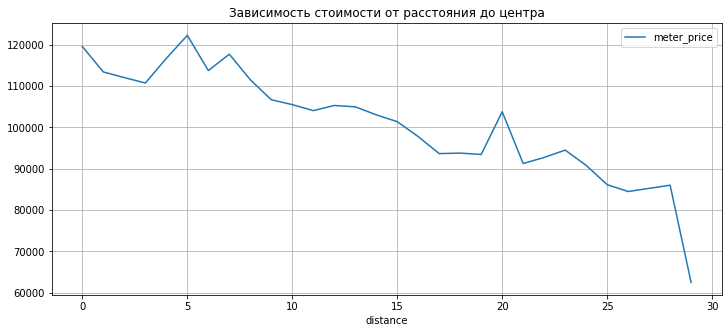

In [20]:
data_spb = data.query('locality_name == "Санкт-Петербург"') #добавил(его небыло)
print(data_spb.pivot_table(index='distance', values='meter_price'))
data_spb.pivot_table(index='distance', values='meter_price').plot(grid=True, figsize=(12, 5), title='Зависимость стоимости от расстояния до центра')

**Вывод:** С удалением от центра Санкт-Петербурга стоимость квадратного метра в целом имеет тенденцию к снижению, тем не менее, максимальная цена квадратного метра имеет место в 5 километрах от центра города.

##### Общий вывод

Проведено исследование рынка жилья в Санкт-Петербурге и Ленинградской области. Мы огранились рассмотрением типичных объектов, в частности, удалили из рассмотрения многокомнатные объединённые квартиры, оставление которых в выборке могло бы внести существенные искажения. 

Гистограммы распределений характеристик объектов показывают, что выставленные на продажу объекты соответствуют типичным объектам региона. Медианный срок продажи объекта - около 3 месяцев, при этом существует группа объектов, которые продаются полтора года и дольше. Кроме того, замечено, что в некоторые дни с продажи снимается большое количество объектов (возможно, с целью выставить их в продажу заново), поэтому реальный медианный срок продажи может оказаться немного дольше. Тем не менее, этих объявлений около 5%, так что существенного искажения они внести не могут.

Цена объекта зависит в наибольшей степени от площади объекта, местоположения объекта (самое дорогое жилье в Санкт-Петербурге, причём не в самом центре, а в 5 км от центра города) и этажа (квартиры на первом и последнем этажах продаются с дисконтом). Выявлена некоторая зависимость цены от площади кухни и жилой площади квартиры, но это может быть опосредованной зависимостью от площади объекта. Цена квартиры также зависит от количества комнат, но нелинейно (в частности, 4-, 5- и более комнатные квартиры стоят не намного дороже 3-х комнатных). Большая часть квартир выставляется на продажу в течение рабочей недели, что говорит о том, что продажами занимаются преимущественно риелторы, а не сами собственники. Кроме характеристик самого объекта недвижимости на цену влияют сезонные колебания спроса, в частности, в летние месяцы квартиры продаются за меньшую стоимость, чем осенний или весенний периоды максимального спроса.